In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/My Drive/data/tiny-imagenet-200.zip"

In [3]:
### Imports ###
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [4]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(121)
tf.random.set_seed(85)

In [5]:
### Constants ###
DATA_DIR = "/content/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

In [6]:
def load_dataset_small(num_images_per_class_train=100, num_images_test=1000):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        #for img_name_i in c_imgs[0:num_images_per_class_train]:
        for img_name_i in c_imgs:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    #for img_name_i in test_imgs[0:num_images_test]:
    for img_name_i in test_imgs:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [7]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 100000
Number of test examples = 10000
X_train shape: (100000, 64, 64, 3)


In [8]:
del X_train_orig, X_test_orig

In [9]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

In [10]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

### Model Implementation


In [11]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(y_true, y_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(y_true - y_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    s_loss = K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    input_K = Input(shape=(4096,))
  
    integer_K = tf.dtypes.cast(input_K, tf.int32)
    i1 = tf.expand_dims(tf.range(tf.shape(integer_K)[0]), axis = 1)
    i1 = tf.tile(i1, [1, 4096])
    indices = tf.stack([i1, integer_K], axis=-1)
    tensor = Reshape(( -1, 3))(input_S)
    shape = tf.shape(tensor)
    scattered_tensor = tf.scatter_nd(indices, tensor, shape)
    x = Reshape((64,64,3))(scattered_tensor)
    

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(x) #changed
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(x) #changed
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C, input_K], #changed
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    input_K = Input(shape=(4096,))

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input) #changed
    x = input_with_noise
   
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(x) #changed
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)

    integer_K = tf.dtypes.cast(input_K, tf.int32)
    i1 = tf.expand_dims(tf.range(tf.shape(integer_K)[0]), axis = 1)
    i1 = tf.tile(i1, [1, 4096])
    indices = tf.stack([i1,integer_K], axis=-1)
    tensor = Reshape(( -1, 3))(x)
    shape = tf.shape(tensor)
    
    scattered_tensor = tf.gather_nd(tensor, indices)
    output_Sprime= Reshape((64,64,3))(scattered_tensor)
    #print(x.shape)
    
    if not fixed:
        return Model(inputs=[reveal_input,input_K],
                     outputs=output_Sprime,
                     name = 'Decoder')
    # else:
    #     return Container(inputs=reveal_input,
    #                      outputs=output_Sprime,
    #                      name = 'DecoderFixed')                    # Changed
    else:
      return Network(inputs=[reveal_input,input_K],   #changed
                      outputs=output_Sprime,
                      name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size)) 
    input_K = Input(shape=(4096,))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C, input_K]) #changed
    output_Sprime = decoder([output_Cprime, input_K]) #changed

    autoencoder = Model(inputs=[input_S, input_C, input_K],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    return encoder, decoder, autoencoder

### 1st 10 Epoch :

In [ ]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.zeros(shape=(len(batch_S), 4096))
          for i in range(len(batch_S)):
            batch_K[i] = random.sample(range(0, 4096), 4096)
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE   14411.05 | Loss Rev   11035.24: 100%|██████████| 1563/1563 [14:36<00:00,  1.78it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    5631.58 | Loss Rev    4219.80: 100%|██████████| 1563/1563 [13:58<00:00,  1.86it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    5624.90 | Loss Rev    4233.11: 100%|██████████| 1563/1563 [13:58<00:00,  1.86it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    5318.80 | Loss Rev    4020.93: 100%|██████████| 1563/1563 [13:56<00:00,  1.87it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    4928.46 | Loss Rev    3656.06: 100%|██████████| 1563/1563 [13:54<00:00,  1.87it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    4106.79 | Loss Rev    2867.44: 100%|██████████| 1563/1563 [13:52<00:00,  1.88it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    3662.71 | Loss Rev    2470.69: 100%|██████████| 1563/1563 [13:47<00:00,  1.89it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    3146.41 | Loss Rev    1893.82: 100%|██████████| 1563/1563 [13:47<00

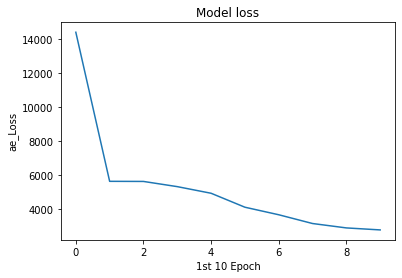

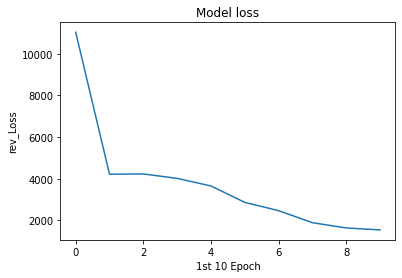

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)

autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_model_100k_10e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_encoder_model_100k_10e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_model_100k_10e.hdf5')

with open('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_100k_10e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_100k_10e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)
        
plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('1st 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('1st 10 Epoch')
plt.show()

### 2nd 10 epochs

In [ ]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_model_100k_10e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_encoder_model_100k_10e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_model_100k_10e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.zeros(shape=(len(batch_S), 4096))
          for i in range(len(batch_S)):
            batch_K[i] = random.sample(range(0, 4096), 4096)
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE    2870.21 | Loss Rev    1579.19: 100%|██████████| 1563/1563 [14:22<00:00,  1.81it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    2605.27 | Loss Rev    1420.54: 100%|██████████| 1563/1563 [13:42<00:00,  1.90it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    2574.07 | Loss Rev    1391.96: 100%|██████████| 1563/1563 [13:42<00:00,  1.90it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    2550.29 | Loss Rev    1362.00: 100%|██████████| 1563/1563 [13:42<00:00,  1.90it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    2504.56 | Loss Rev    1334.99: 100%|██████████| 1563/1563 [13:45<00:00,  1.89it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    2542.26 | Loss Rev    1361.54: 100%|██████████| 1563/1563 [13:45<00:00,  1.89it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    2441.55 | Loss Rev    1315.52: 100%|██████████| 1563/1563 [13:44<00:00,  1.90it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    2411.69 | Loss Rev    1304.19: 100%|██████████| 1563/1563 [13:45<00

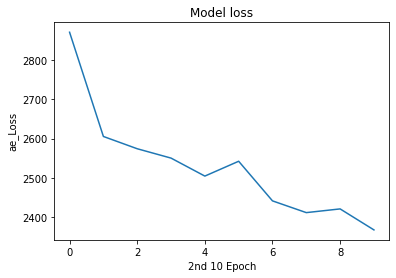

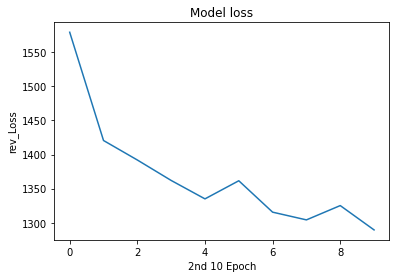

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)

autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_model_100k_20e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_encoder_model_100k_20e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_model_100k_20e.hdf5')

with open('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_100k_20e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_100k_20e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)
        
plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('2nd 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('2nd 10 Epoch')
plt.show()

### 3rd 10 epoch

In [ ]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_model_100k_20e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_encoder_model_100k_20e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_model_100k_20e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.zeros(shape=(len(batch_S), 4096))
          for i in range(len(batch_S)):
            batch_K[i] = random.sample(range(0, 4096), 4096)
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE    2660.55 | Loss Rev    1580.92: 100%|██████████| 1563/1563 [14:21<00:00,  1.81it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    2336.95 | Loss Rev    1338.91: 100%|██████████| 1563/1563 [13:46<00:00,  1.89it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    2326.58 | Loss Rev    1361.46: 100%|██████████| 1563/1563 [13:40<00:00,  1.90it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    2260.12 | Loss Rev    1394.94: 100%|██████████| 1563/1563 [13:39<00:00,  1.91it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    2173.25 | Loss Rev    1386.83: 100%|██████████| 1563/1563 [13:40<00:00,  1.90it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    2098.88 | Loss Rev    1331.75: 100%|██████████| 1563/1563 [13:39<00:00,  1.91it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    2070.76 | Loss Rev    1308.95: 100%|██████████| 1563/1563 [13:42<00:00,  1.90it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    2075.76 | Loss Rev    1311.37: 100%|██████████| 1563/1563 [13:40<00

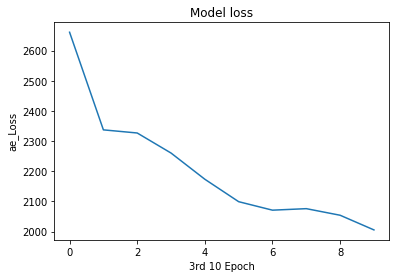

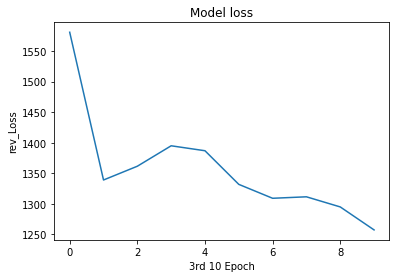

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)

autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_model_100k_30e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_encoder_model_100k_30e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_model_100k_30e.hdf5')

with open('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_100k_30e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_100k_30e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)
        
plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('3rd 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('3rd 10 Epoch')
plt.show()

### 4th 10 Epoch :

In [ ]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_model_100k_30e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_encoder_model_100k_30e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_model_100k_30e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.zeros(shape=(len(batch_S), 4096))
          for i in range(len(batch_S)):
            batch_K[i] = random.sample(range(0, 4096), 4096)
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE    2073.30 | Loss Rev    1303.74: 100%|██████████| 1563/1563 [14:09<00:00,  1.84it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    2006.45 | Loss Rev    1259.41: 100%|██████████| 1563/1563 [13:30<00:00,  1.93it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    1996.63 | Loss Rev    1250.19: 100%|██████████| 1563/1563 [13:31<00:00,  1.93it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    1994.69 | Loss Rev    1251.21: 100%|██████████| 1563/1563 [13:32<00:00,  1.92it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    1976.58 | Loss Rev    1232.53: 100%|██████████| 1563/1563 [13:33<00:00,  1.92it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    1972.26 | Loss Rev    1230.33: 100%|██████████| 1563/1563 [13:34<00:00,  1.92it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    1967.14 | Loss Rev    1227.92: 100%|██████████| 1563/1563 [13:35<00:00,  1.92it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    1953.53 | Loss Rev    1215.59: 100%|██████████| 1563/1563 [13:34<00

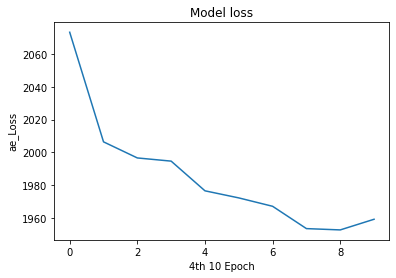

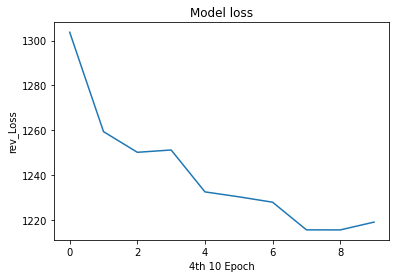

In [ ]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)

autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_model_100k_40e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_encoder_model_100k_40e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_model_100k_40e.hdf5')

with open('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_100k_40e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_100k_40e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)
        
plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('4th 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('4th 10 Epoch')
plt.show()

### 5th 10 Epoch :

In [12]:
def Train(e) :
  NB_EPOCHS = e
  BATCH_SIZE = 32
  m = input_S.shape[0]
  ae_loss_history = []
  rev_loss_history = []
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_model_100k_40e.hdf5')
  encoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_encoder_model_100k_40e.hdf5')
  reveal_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_model_100k_40e.hdf5')
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
      ae_loss = []
      rev_loss = []
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          batch_K = np.zeros(shape=(len(batch_S), 4096))
          for i in range(len(batch_S)):
            batch_K[i] = random.sample(range(0, 4096), 4096)
          
          C_prime = encoder_model.predict([batch_S, batch_C, batch_K])
          
          ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C, batch_K], y=np.concatenate((batch_S, batch_C),axis=3)))
          rev_loss.append(reveal_model.train_on_batch(x=[C_prime,batch_K],y=batch_S))
          
          # Update learning rate
          K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
          K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      ae_loss_history.append(np.mean(ae_loss))
      rev_loss_history.append(np.mean(rev_loss))
  return ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model 

Epoch 1 | Batch: 49984 of 50000. Loss AE    1995.13 | Loss Rev    1242.61: 100%|██████████| 1563/1563 [14:16<00:00,  1.82it/s]
Epoch 2 | Batch: 49984 of 50000. Loss AE    1934.96 | Loss Rev    1203.59: 100%|██████████| 1563/1563 [13:30<00:00,  1.93it/s]
Epoch 3 | Batch: 49984 of 50000. Loss AE    1935.04 | Loss Rev    1201.07: 100%|██████████| 1563/1563 [13:28<00:00,  1.93it/s]
Epoch 4 | Batch: 49984 of 50000. Loss AE    1934.58 | Loss Rev    1200.17: 100%|██████████| 1563/1563 [13:29<00:00,  1.93it/s]
Epoch 5 | Batch: 49984 of 50000. Loss AE    1923.52 | Loss Rev    1191.38: 100%|██████████| 1563/1563 [13:27<00:00,  1.93it/s]
Epoch 6 | Batch: 49984 of 50000. Loss AE    1923.61 | Loss Rev    1193.03: 100%|██████████| 1563/1563 [13:31<00:00,  1.93it/s]
Epoch 7 | Batch: 49984 of 50000. Loss AE    1931.72 | Loss Rev    1196.94: 100%|██████████| 1563/1563 [13:31<00:00,  1.93it/s]
Epoch 8 | Batch: 49984 of 50000. Loss AE    1911.61 | Loss Rev    1182.28: 100%|██████████| 1563/1563 [13:35<00

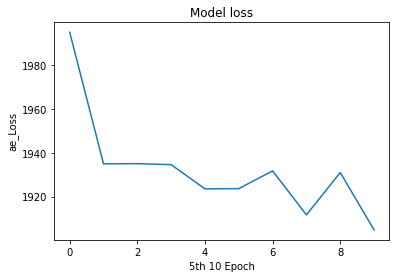

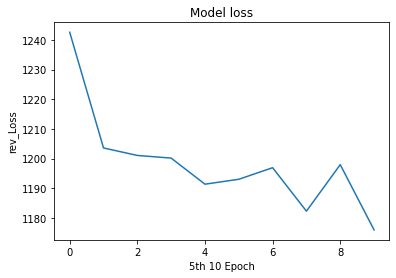

In [13]:
ae_loss_history, rev_loss_history, encoder_model, reveal_model, autoencoder_model = Train(10)

autoencoder_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_model_100k_50e.hdf5')
encoder_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_encoder_model_100k_50e.hdf5')
reveal_model.save_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_model_100k_50e.hdf5')

with open('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_100k_50e.txt', 'w') as f:
    for item in ae_loss_history:
        f.write("%s," % item)
with open('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_100k_50e.txt', 'w') as f:
    for item in rev_loss_history:
        f.write("%s," % item)
        
plt.plot(ae_loss_history)
plt.title('Model loss')
plt.ylabel('ae_Loss')
plt.xlabel('5th 10 Epoch')
plt.show()
plt.plot(rev_loss_history)
plt.title('Model loss')
plt.ylabel('rev_Loss')
plt.xlabel('5th 10 Epoch')
plt.show()

### Test 

In [ ]:
# S: secret image
input_S = X_test[0:X_test.shape[0] // 2]

# C: cover image
input_C = X_test[X_test.shape[0] // 2:]

In [ ]:
input_K = np.zeros(shape=(len(input_S), 4096))
for i in range(len(input_S)):
    input_K[i] = random.sample(range(0, 4096), 4096)

In [ ]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
autoencoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_autoencoder_model_100k_50e.hdf5')
encoder_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_encoder_model_100k_50e.hdf5')
reveal_model.load_weights('/content/drive/My Drive/Final_Model/one_block_shuffling/one_block_shuffling_reveal_model_100k_50e.hdf5')

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    rmse_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    rmse_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return rmse_Spixel, rmse_Cpixel

In [ ]:
decoded = autoencoder_model.predict([input_S, input_C, input_K])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

In [ ]:
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)